## **PAIR ASSIGNMENT**

Please work in pairs for this exercise. Pair up with the person next to you. If you find that there isn't anyone sitting next to you or if you're unable to form a pair, please raise your hand, and I will assist in pairing you with someone.


#### **TODO: Please assign your full name and your partner's full name to the variables below, respectively.**


Example:

```
your_name = 'Fatma Tarlaci'
your_partner_name = 'Sagnik Majumder'

In [ ]:
# Assign your and your partner's names here.  If you find that there isn't anyone sitting next to you or if you're unable to form a pair, please raise your hand.
# If, in the end, we are unable to find a partner for you, please assign the word "self" to the `your_partner_name` variable.
your_name = ''
your_partner_name = ''

#if you are in a group of 3
#your_partner_name = '1st partner fullname, second partner fullname'

# **In Class Exercise: Transformer Attention**

**Goal:** implement and *understand* scaled dot‑product attention, masking, multi‑head attention, and positional encodings on a tiny toy task you can finish fast.

### What you you will do
1. Implement `scaled_dot_product_attention(Q, K, V, mask=None)`.
2. Visualize how scaling by $\sqrt{d_k}$ changes the softmax distribution.
3. Add **causal masking** and confirm it prevents peeking ahead.
4. Implement a minimal **MultiHeadAttention** (no dropout, no bias complexity) and compare to PyTorch's reference.
5. Add **sinusoidal positional encodings** and verify shape & behavior.
6. Run a tiny **copy task** to see masked attention work end‑to‑end.

In [2]:
# Setup
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datasets import load_dataset

# Use GPU when available for faster training/visuals; fall back to CPU otherwise
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using', DEVICE)


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cuda


In [4]:
ds = load_dataset("wikitext", "wikitext-2-v1")

Generating validation split: 100%|██████████| 3760/3760 [00:00<00:00, 470510.86 examples/s]


In [7]:
print(ds)
for i in range(5):
    print(ds['train'][i])

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})
{'text': ''}
{'text': ' = Valkyria Chronicles III = \n'}
{'text': ''}
{'text': ' Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . <unk> the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the 

In [ ]:
from transformers import AutoTokenizer

In [20]:
model_name = 'gpt2'
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
# enc = tokenizer(sentence, return_tensors='pt')

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\huggingface_hub\file_download.py:121: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Owner\.cache\huggingface\hub\models--openai-community--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


RemoteEntryNotFoundError: 404 Client Error. (Request ID: Root=1-691ca3ef-1a98065045b7c21c4caac42d;168fd61c-489d-4efd-ba82-5722471b92d1)

Entry Not Found for url: https://huggingface.co/api/models/openai-community/gpt2/tree/main/additional_chat_templates?recursive=false&expand=false.
additional_chat_templates does not exist on "main"

## 1) **Implement scaled dot‑product attention**
Complete the function below. Follow the equation from lecture:
$\text{Attn}(Q,K,V) = \text{softmax}\!\left(\frac{QK^\top}{\sqrt{d_k}} + M\right) V$
where **M** is an (optional) additive mask with `-inf` on disallowed positions.

* Run the code cell and verify the printed shape message. After running, inspect `out` and `attn` shapes printed by the quick shape test. If the assertion fails, check tensor dims: Q/K should end in `d_k` and V should end in `d_v`.

In [8]:
def scaled_dot_product_attention(Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor, mask: torch.Tensor|None=None):
    """Compute scaled dot-product attention.

    Implements the equation from "Attention is All You Need":

        Attention(Q, K, V) = softmax(Q K^T / sqrt(d_k) + mask) V

    Args:
        Q: Query tensor of shape (B, h, T_q, d_k).
        K: Key tensor of shape (B, h, T_k, d_k).
        V: Value tensor of shape (B, h, T_k, d_v).
        mask: Optional additive mask broadcastable to (B, h, T_q, T_k) with 0 or -inf.

    Returns:
        out: Attention output, shape (B, h, T_q, d_v).
        attn: Attention weights (softmax probabilities), shape (B, h, T_q, T_k).
    """
    # d_k is the dimensionality of queries/keys per head
    d_k = Q.size(-1)  # read last dimension of Q for scaling

    # Compute raw attention scores by matrix-multiplying Q and K^T
    # Q @ K^T yields shape (B, h, T_q, T_k)
    #TODO
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)# scale by sqrt(d_k)

    # If a mask was provided, add it to the scores. Mask entries are 0 (keep) or -inf (block)
    if mask is not None:
        # Ensure mask is same dtype and on same device as scores to avoid runtime errors
        mask = mask.to(dtype=scores.dtype, device=scores.device)
        scores = scores + mask  # additive masking prior to softmax

    # Convert scores to probabilities along the key dimension with softmax
    # use torch functional library you important above, which is a PyTorch
    # module containing functional (stateless) implementations of layers
    # and operations like softmax, relu, cross_entropy, etc.
    #TODO
    attn = F.softmax(scores, dim=-1)  # softmax over T_k

    # Use attention weights to produce weighted sum over values
    # This line of code will perform a batched matrix multiplication over the last two dimensions
    out = torch.matmul(attn, V) # (B, h, T_q, d_v)

    # Return both the attended outputs and the attention weights for inspection
    return out, attn

# Quick shape test: verify the function returns expected tensor shapes
B, h, T, d_k, d_v = 2, 3, 4, 8, 8  # batch, heads, time, key-dim, value-dim
Q = torch.randn(B, h, T, d_k)  # random queries
K = torch.randn(B, h, T, d_k)  # random keys
V = torch.randn(B, h, T, d_v)  # random values
out, attn = scaled_dot_product_attention(Q, K, V)  # call the function
assert out.shape == (B, h, T, d_v) and attn.shape == (B, h, T, T)  # sanity assert
print('Scaled dot-product attention shapes OK:', out.shape, attn.shape)


Scaled dot-product attention shapes OK: torch.Size([2, 3, 4, 8]) torch.Size([2, 3, 4, 4])


## 2) Visualize scaling vs. no scaling
We'll show how dividing logits by $\sqrt{d_k}$ prevents softmax saturation.

Student instructions: Run the plot cell and observe the two curves. Use this visual to answer question 1 in the 'Quick questions' section. If the plot is not visible, ensure your notebook's plotting backend is enabled (e.g., `%matplotlib inline`).

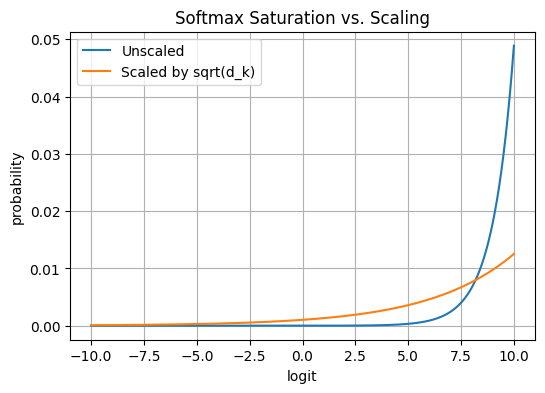

In [9]:
import numpy as np
x = torch.linspace(-10, 10, 400)
unscaled = torch.softmax(x, dim=0)
scaled = torch.softmax(x/4, dim=0)
plt.figure(figsize=(6,4))
plt.plot(x, unscaled, label='Unscaled')
plt.plot(x, scaled, label='Scaled by sqrt(d_k)')
plt.legend(); plt.title('Softmax Saturation vs. Scaling'); plt.xlabel('logit'); plt.ylabel('probability'); plt.grid(True)
plt.show()

## 3) Add a **causal mask**
Construct a mask that forbids attending to future positions. Verify the last column in the attention matrix for token *t* is zero for all columns > *t*.

What is a mask and why we use it:

- A mask is an additive tensor M that you add to the raw attention logits before the softmax:

  $$\mathrm{Attention}(Q,K,V)=\operatorname{softmax}\left(\frac{QK^{\top}}{\sqrt{d_k}}+M\right)\;V.$$

- Mask values are chosen so that allowed positions get 0.0 and disallowed positions get a very large negative number (ideally $-\infty$). After softmax, masked positions become (near) zero probability.
- Typical representation:
  - Allowed: 0.0
  - Blocked: `float('-inf')` or a large negative like `-1e9` (for numeric stability)
- Mask shape and broadcasting: M must be broadcastable to `(B, h, T_q, T_k)`. Often we create it as shape `(1, 1, T_q, T_k)` so it broadcasts over batch and heads.

Why use a causal mask in autoregressive attention:

- Enforces causality / no-peeking: for autoregressive decoding (predicting token $t$), the model must not attend to future tokens $t' > t$. A causal mask zeros out attention to future positions so the prediction for position $t$ depends only on positions $\le t$.
- Maintains correctness while allowing parallelism: instead of iterating time steps sequentially, we can compute attention for all query positions in parallel and use the mask to prevent illegal attention — fast and efficient on modern hardware.
- Keeps gradients and learned behavior correct: prevents the model from learning to “cheat” by seeing future tokens during training.
- Works with scaled logits: you mask after computing $QK^{\top} / \sqrt{d_k}$ so the mask blocks by pushing logits to $-\infty$ before softmax, ensuring probability mass goes to allowed keys only.

Practical tips and common pitfalls:

- Use additive masking (add before softmax) rather than multiplying probabilities — additive mask is standard and numerically stable.
- If using `float('-inf')` causes issues on some dtypes/environments, use a large negative like `-1e9` (or `torch.finfo(dtype).min`).
- Ensure mask and logits are on the same device and same dtype (scores are float32/float64): mismatched device/dtype -> errors.
- Broadcasting: create masks with leading dims `(1,1,T_q,T_k)` so they broadcast over batch/head dims.
- Check results: after applying a causal mask, inspect an attention matrix slice (e.g., `attn[0,0]`) — the upper triangle should be ~0 and the lower triangle should contain the probability mass.
- Order: scale (divide by $\sqrt{d_k}$) first, then add mask, then softmax.

Student instructions: Run the causal mask cell and check the printed attention slice. Confirm the upper-triangular entries are ~0 (or very small). If not, re-run the `scaled_dot_product_attention` cell first.

In [10]:
def causal_mask(T_q: int, T_k: int, device=DEVICE, dtype: torch.dtype=torch.float32):
    """Create an additive causal mask to prevent attention to future positions.

    The mask returned can be added directly to attention logits before softmax.

    Args:
        T_q: Number of query positions.
        T_k: Number of key/value positions.
        device: Torch device to create the mask on.
        dtype: Desired floating dtype for the returned mask (default: torch.float32).

    Returns:
        mask: Tensor of shape (1, 1, T_q, T_k) with 0.0 where allowed and -inf where masked.
    """
    # Allocate a mask filled with -inf (all positions masked initially) with requested dtype
    mask = torch.full((1,1,T_q,T_k), float('-inf'), device=device, dtype=dtype)

    # Build a lower-triangular matrix of ones (allowed positions are 1)
    tril = torch.tril(torch.ones(T_q, T_k, device=device, dtype=dtype))

    # Wherever tril == 1, set the mask value to 0.0 (meaning "allowed")
    mask = mask.masked_fill(tril == 1, 0.0)

    # Return mask shaped (1,1,T_q,T_k) which will broadcast over batch and heads
    return mask

# Quick visual/print check to ensure masked attention has zeros in upper triangle
B, h, T, d = 1, 2, 6, 8  # small example sizes for demonstration
Q = torch.randn(B,h,T,d)  # random queries
K = torch.randn(B,h,T,d)  # random keys
V = torch.randn(B,h,T,d)  # random values
mask = causal_mask(T, T, dtype=Q.dtype)  # create causal mask with same dtype as Q
_, attn = scaled_dot_product_attention(Q,K,V,mask)  # compute attention with mask
print('Masked attention OK, upper-triangular ~ 0? Check a head slice:')
print(attn[0,0])  # print attention weights for head 0, batch 0


Masked attention OK, upper-triangular ~ 0? Check a head slice:
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8946, 0.1054, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0972, 0.6552, 0.2476, 0.0000, 0.0000, 0.0000],
        [0.5203, 0.1162, 0.1529, 0.2105, 0.0000, 0.0000],
        [0.1604, 0.4032, 0.2410, 0.0516, 0.1438, 0.0000],
        [0.1956, 0.4167, 0.2108, 0.1046, 0.0033, 0.0691]])


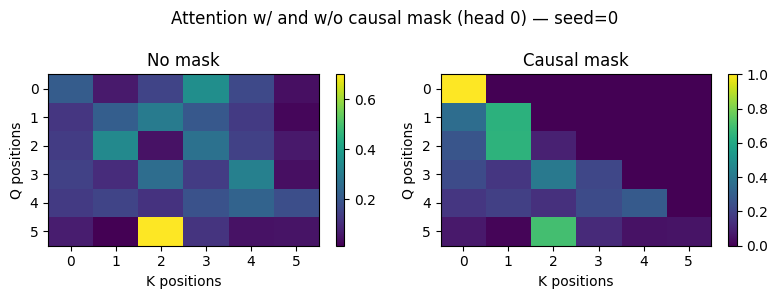

No mask (head 0):
[[0.21540135 0.06506788 0.15650567 0.35373983 0.16621134 0.04307392]
 [0.12202097 0.21948774 0.298775   0.20350027 0.13051514 0.02570083]
 [0.13688588 0.33674195 0.04816442 0.26923117 0.14685872 0.06211788]
 [0.14624612 0.10104137 0.25992575 0.13745917 0.31277347 0.04255417]
 [0.13008599 0.15593511 0.11460779 0.18676016 0.23297416 0.17963682]
 [0.06876864 0.01484222 0.69988006 0.11729048 0.04744559 0.05177303]]

Causal mask (head 0):
[[1.         0.         0.         0.         0.         0.        ]
 [0.35729975 0.64270025 0.         0.         0.         0.        ]
 [0.2623379  0.64535636 0.09230573 0.         0.         0.        ]
 [0.22685339 0.1567329  0.4031904  0.2132233  0.         0.        ]
 [0.15857121 0.19008057 0.13970372 0.22765546 0.28398904 0.        ]
 [0.06876864 0.01484222 0.69988006 0.11729048 0.04744559 0.05177303]]


In [11]:
# Demo: compare attention matrices with and without causal mask (T=6)
import matplotlib.pyplot as plt
import numpy as np
import random

# Deterministic seed (change this integer to get different but reproducible demos)
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    # For reproducibility when using CUDA, set cuDNN to deterministic mode
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

B, h, T, d = 1, 1, 6, 8
Q = torch.randn(B,h,T,d)
K = torch.randn(B,h,T,d)
V = torch.randn(B,h,T,d)
# No mask (allow attending everywhere)
_, attn_no_mask = scaled_dot_product_attention(Q, K, V, mask=None)
# Causal mask (no peeking ahead)
mask = causal_mask(T, T, device=Q.device)
_, attn_causal = scaled_dot_product_attention(Q, K, V, mask=mask)
# Squeeze to 2D for plotting: (T_q, T_k)
a0 = attn_no_mask[0,0].cpu().numpy()
a1 = attn_causal[0,0].cpu().numpy()
plt.figure(figsize=(8,3))
plt.subplot(1,2,1); plt.title('No mask'); plt.imshow(a0, aspect='auto', interpolation='nearest'); plt.colorbar(); plt.xlabel('K positions'); plt.ylabel('Q positions')
plt.subplot(1,2,2); plt.title('Causal mask'); plt.imshow(a1, aspect='auto', interpolation='nearest'); plt.colorbar(); plt.xlabel('K positions'); plt.ylabel('Q positions')
plt.suptitle(f'Attention w/ and w/o causal mask (head 0) — seed={seed}')
plt.tight_layout(); plt.show()

# Print a small numeric slice to inspect zeros above diagonal
print('No mask (head 0):')
print(a0)
print('\nCausal mask (head 0):')
print(a1)


### Demo notes — what to look for

Run the demo cell below. You should see two heatmaps side-by-side:

- Left: attention *without* a causal mask — values may be nonzero across the matrix.
- Right: attention *with* a causal mask — the upper triangle should be zero (no peeking ahead).

Also inspect the printed numeric arrays. In the causal-masked matrix, entries above the diagonal should be near-zero. If the masked matrix still has large values above the diagonal, re-check that the mask uses `-inf` (or a very large negative) and is added to the scaled logits before the softmax.

## 4) Minimal Multi‑Head Attention (from scratch)
Implement a simplified `MultiHeadAttention` that projects Q/K/V, applies attention, concatenates heads, and outputs via `W^O`. Compare to `torch.nn.MultiheadAttention` on shapes.

Student instructions: Run the TinyMultiHeadAttention cell and confirm the printed shapes. After running, inspect `attn`'s shape (should be `(B, h, T, T)`) and ensure `y` shape is `(B, T, D)`. If shapes mismatch, check `d_model` vs `num_heads`.

In [12]:
class TinyMultiHeadAttention(nn.Module):
    """A minimal multi-head self-attention implementation.

    This class implements the core mechanics of multi-head attention without
    dropout or biases. It projects inputs to Q/K/V, splits into heads, applies
    scaled dot-product attention per head, and concatenates the results.
    """
    def __init__(self, d_model: int, num_heads: int):
        super().__init__()
        # Ensure d_model is divisible by number of heads for equal head size
        assert d_model % num_heads == 0
        self.d_model = d_model  # full model dimensionality
        self.num_heads = num_heads  # number of parallel attention heads
        self.d_k = d_model // num_heads  # dimensionality per head

        # Linear projections for queries, keys and values (project then split into heads)
        self.W_q = nn.Linear(d_model, d_model, bias=False)  # projects input -> Q_all
        self.W_k = nn.Linear(d_model, d_model, bias=False)  # projects input -> K_all
        self.W_v = nn.Linear(d_model, d_model, bias=False)  # projects input -> V_all

        # Output linear projection that combines concatenated head outputs
        self.W_o = nn.Linear(d_model, d_model, bias=False)  # projects heads concat -> output

    def split_heads(self, X):
        """Split the last dimension into (num_heads, d_k) and transpose.

        Args:
            X: Tensor of shape (B, T, D)
        Returns:
            Tensor of shape (B, h, T, d_k)
        """
        # Unpack batch, time, and feature dims
        B, T, D = X.shape
        # Reshape to separate heads and then transpose head dim upfront
        X = X.view(B, T, self.num_heads, self.d_k).transpose(1,2)  # (B,h,T,d_k)
        return X

    def combine_heads(self, X):
        """Inverse of split_heads: transpose and merge heads into feature dim.

        Args:
            X: Tensor of shape (B, h, T, d_k)
        Returns:
            Tensor of shape (B, T, D)
        """
        # Unpack shapes
        B, h, T, d_k = X.shape
        # Transpose to (B, T, h, d_k) then flatten the last two dims
        X = X.transpose(1,2).contiguous().view(B, T, h*d_k)  # (B,T,D)
        return X

    def forward(self, X, mask=None):
        """Forward pass for TinyMultiHeadAttention.

        Args:
            X: Input tensor of shape (B, T, D=d_model).
            mask: Optional additive mask to apply to attention logits.

        Returns:
            out_proj: Output tensor of shape (B, T, D).
            attn: Attention weights from scaled_dot_product_attention (B, h, T, T).
        """
        # Project inputs to combined Q/K/V of shape (B, T, D)
        Q_all = self.W_q(X)  # (B, T, D)
        K_all = self.W_k(X)  # (B, T, D)
        V_all = self.W_v(X)  # (B, T, D)

        # Split the combined Q/K/V into multiple heads: (B, h, T, d_k)
        Q = self.split_heads(Q_all)
        K = self.split_heads(K_all)
        V = self.split_heads(V_all)

        # Compute attention per head using scaled dot-product attention
        out, attn = scaled_dot_product_attention(Q, K, V, mask)

        # Combine head outputs back into (B, T, D)
        out_combined = self.combine_heads(out)

        # Final linear projection
        out_proj = self.W_o(out_combined)

        return out_proj, attn

# Sanity check
B,T,D,h = 2,5,32,4
x = torch.randn(B,T,D)
mha = TinyMultiHeadAttention(D,h)
y, attn = mha(x)
print('Tiny MHA out shape:', y.shape, '| attn:', attn.shape)


Tiny MHA out shape: torch.Size([2, 5, 32]) | attn: torch.Size([2, 4, 5, 5])


## 5) Sinusoidal positional encodings
Implement the classic sinusoidal encoding and add it to token embeddings. Verify shape and visualize a few dimensions.

Student instructions: Run the positional encoding cell and inspect the heatmap. Confirm the returned `PE` has shape `(T, d_model)` and that alternating dimensions show sin/cos patterns. If plotting fails, ensure `matplotlib` is imported and running in this notebook.

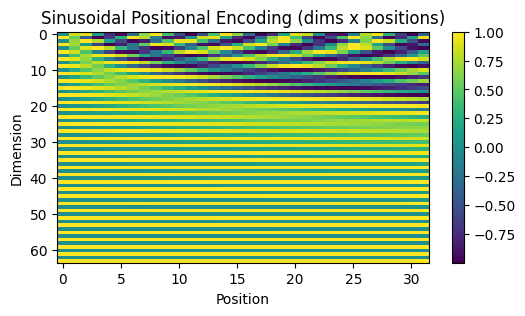

In [13]:
def sinusoidal_positional_encoding(T:int, d_model:int, device=DEVICE):
    """Create sinusoidal positional encodings.

    Implements the original formulation from Vaswani et al. where each dimension
    of the positional encoding uses a different frequency.

    Args:
        T: Sequence length (number of positions).
        d_model: Model dimensionality (must be even to pair sin/cos dims nicely).
        device: Torch device for the returned tensor.

    Returns:
        PE: Tensor of shape (T, d_model) containing positional encodings.
    """
    # Ensure d_model is even so even/odd pairing works
    assert d_model % 2 == 0, "d_model must be even for sinusoidal positional encoding"

    # position indices (T, 1) as float
    pos = torch.arange(T, device=device, dtype=torch.float32).unsqueeze(1)

    # dimension indices (1, d_model) as float
    i = torch.arange(d_model, device=device, dtype=torch.float32).unsqueeze(0)

    # compute the rate term 1/10000^{2i/d_model}
    angle_rates = 1.0 / torch.pow(10000.0, (2 * (i // 2)) / d_model)

    # outer product to get angles for every position and dimension
    angles = pos * angle_rates  # (T, d_model)

    # allocate and fill even/odd indices with sin/cos
    PE = torch.zeros((T, d_model), device=device)
    PE[:, 0::2] = torch.sin(angles[:, 0::2])
    PE[:, 1::2] = torch.cos(angles[:, 1::2])
    return PE

# Quick visualization
T, D = 32, 64
PE = sinusoidal_positional_encoding(T, D)
plt.figure(figsize=(6,3))
plt.imshow(PE.cpu().numpy().T, aspect='auto', interpolation='nearest')
plt.title('Sinusoidal Positional Encoding (dims x positions)')
plt.xlabel('Position'); plt.ylabel('Dimension'); plt.colorbar(); plt.show()


## 6) Tiny copy task (autoregressive)
Use masked attention to perform a simple copy task on a short vocabulary. This is not about performance—just see masking and attention weights do the right thing.

Student instructions: Run the TinyDecoder cell to train briefly. Watch the printed losses every 50 steps and inspect the final printed sample (target vs. predict). Then view the attention heatmap; it should be lower-triangular. If training is slow, reduce `B` or number of steps in the loop.

step 50: loss=0.000
step 100: loss=0.000
step 150: loss=0.000
step 200: loss=0.000
target : [1, 6, 3, 9, 11, 1, 5, 4, 3, 1]
predict: [1, 6, 3, 9, 11, 1, 5, 4, 3, 1]


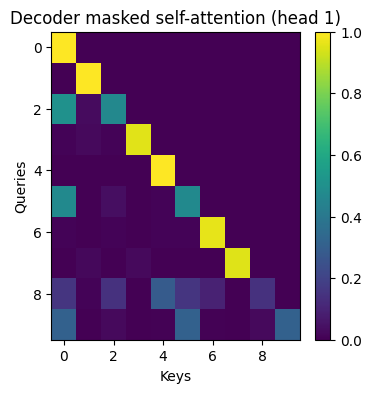

In [14]:
class TinyDecoder(nn.Module):
    """Small autoregressive decoder used for the copy toy task.

    This module contains an embedding layer, a multi-head self-attention block,
    a position-wise feed-forward network, and a linear language model head.
    """
    def __init__(self, vocab_size=12, d_model=64, num_heads=4):
        super().__init__()
        # Token embedding layer maps token ids to d_model vectors
        self.emb = nn.Embedding(vocab_size, d_model)

        # Multi-head self-attention module (applies causal masking externally)
        self.mha = TinyMultiHeadAttention(d_model, num_heads)

        # Simple position-wise feed-forward network (two-layer MLP)
        self.ff = nn.Sequential(
            nn.Linear(d_model, 4*d_model),
            nn.ReLU(),
            nn.Linear(4*d_model, d_model),
        )

        # Final linear projection to vocabulary logits
        self.lm = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        """Forward pass for the tiny autoregressive decoder.

        Args:
            x: Token id tensor of shape (B, T).

        Returns:
            logits: Unnormalized vocab logits of shape (B, T, vocab_size).
            attn: Attention weights from the self-attention module (B, h, T, T).
        """
        # Batch and sequence length
        B, T = x.shape

        # Embed input token ids -> (B, T, d_model)
        h = self.emb(x)

        # Construct causal mask to prevent attending to future positions
        mask = causal_mask(T, T, device=h.device)

        # Apply multi-head attention with the mask
        y, attn = self.mha(h, mask)

        # Apply feed-forward network position-wise
        y = self.ff(y)

        # Project to vocabulary logits
        logits = self.lm(y)

        return logits, attn

# Train briefly on copy task
torch.manual_seed(0)
vocab = 12
model = TinyDecoder(vocab_size=vocab).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=3e-3)

def make_batch(B=64, T=12):
    """Create a batch of random sequences and corresponding copy targets.

    Args:
        B: batch size
        T: sequence length
    Returns:
        x: input token ids (B, T)
        y: target token ids (B, T)
    """
    x = torch.randint(1, vocab, (B,T), device=DEVICE)
    y = x.clone()  # copy task
    return x, y

for step in range(200):
    x, y = make_batch()
    logits, attn = model(x)
    loss = F.cross_entropy(logits.view(-1, vocab), y.view(-1))
    opt.zero_grad(); loss.backward(); opt.step()
    if (step+1)%50==0:
        print(f'step {step+1}: loss={loss.item():.3f}')

# Inspect one sample
x, y = make_batch(B=1, T=10)
with torch.no_grad():
    logits, attn = model(x)
pred = logits.argmax(dim=-1)
print('target :', y.squeeze().tolist())
print('predict:', pred.squeeze().tolist())
plt.figure(figsize=(4,4))
plt.imshow(attn[0,0].cpu().numpy(), aspect='auto', interpolation='nearest')
plt.title('Decoder masked self-attention (head 1)')
plt.xlabel('Keys'); plt.ylabel('Queries'); plt.colorbar(); plt.show()


## **Quick discussion questions - discuss with your partner (not for submission)**
1. Why do we divide by $\sqrt{d_k}$? Use the plot to explain in 2–3 sentences.
2. Show a small attention matrix (e.g., T=6) **with** and **without** a causal mask and describe the difference.
3. In your own words, how do **queries**, **keys**, and **values** differ conceptually?
4. What does multi‑head attention buy you vs. a single head on the copy toy task?

Student instructions: Answer the questions using the figures and prints you generated above. For question 2, re-run the scaled attention + causal mask cells with `T=6` to get the matrices to include in your notebook. Submit this notebook with outputs visible.